# Model Based Machine Learning

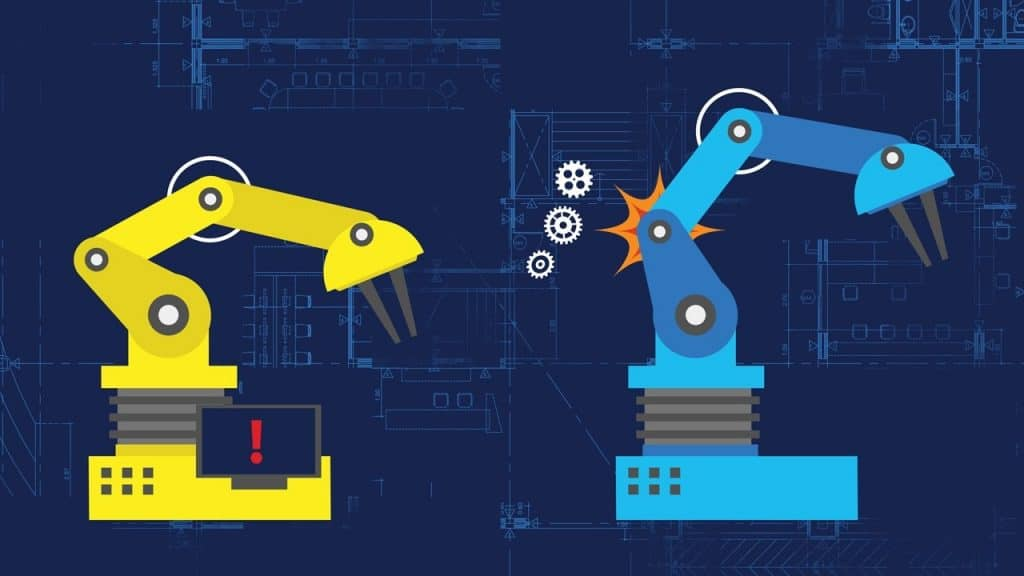

In [21]:
from IPython import display
display.Image("https://www.analyticsinsight.net/wp-content/uploads/2021/01/Predictive-Maintainance-1024x576.jpg")

In [3]:
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline

#matplotlib style options
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)

# Loading data from the different sources

In order to build our predictive maintenance system, we will consider data from 5 sources:

* **Machine conditions and usage**: The operating conditions of a machine e.g. data collected from sensors.
* **Error history**: The history of error codes from the machine.
* **Maintenance history**: The repair history of a machine, e.g. previous maintenance activities or component replacements.
* **Machine features**: The features of a machine, e.g. engine size, make and model, location.
* **Failure history**: The failure history of a machine or component within the machine.

The raw data from these sources was already pre-processed, and relevant features were extracted from it in order to be used in this notebook.

## Machine conditions and usage
It corresponds to sensor data and includes voltage, rotation, pressure and vibration. The raw data was very high-resolution (every 1h) for the problem that we are trying to solve (predict failures 24h in advance). Therefore, for each sensor, features were extracted corresponding to the mean ("mean") and standard deviation ("sd") of the sensor in last 3h, and also in the last 24h window.

In [7]:
# load data from csv
telemetry = pd.read_csv('data/telemetry.csv')

# format datetime field which comes in as string
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

# show first rows
telemetry.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,15.726970,39.648116,11.904700,5.601191
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,15.635083,41.828592,11.326412,5.583521
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.995465,40.843882,11.036546,5.561553
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.100364,43.409841,10.972862,6.068674
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.808489,43.742304,10.988704,7.286129


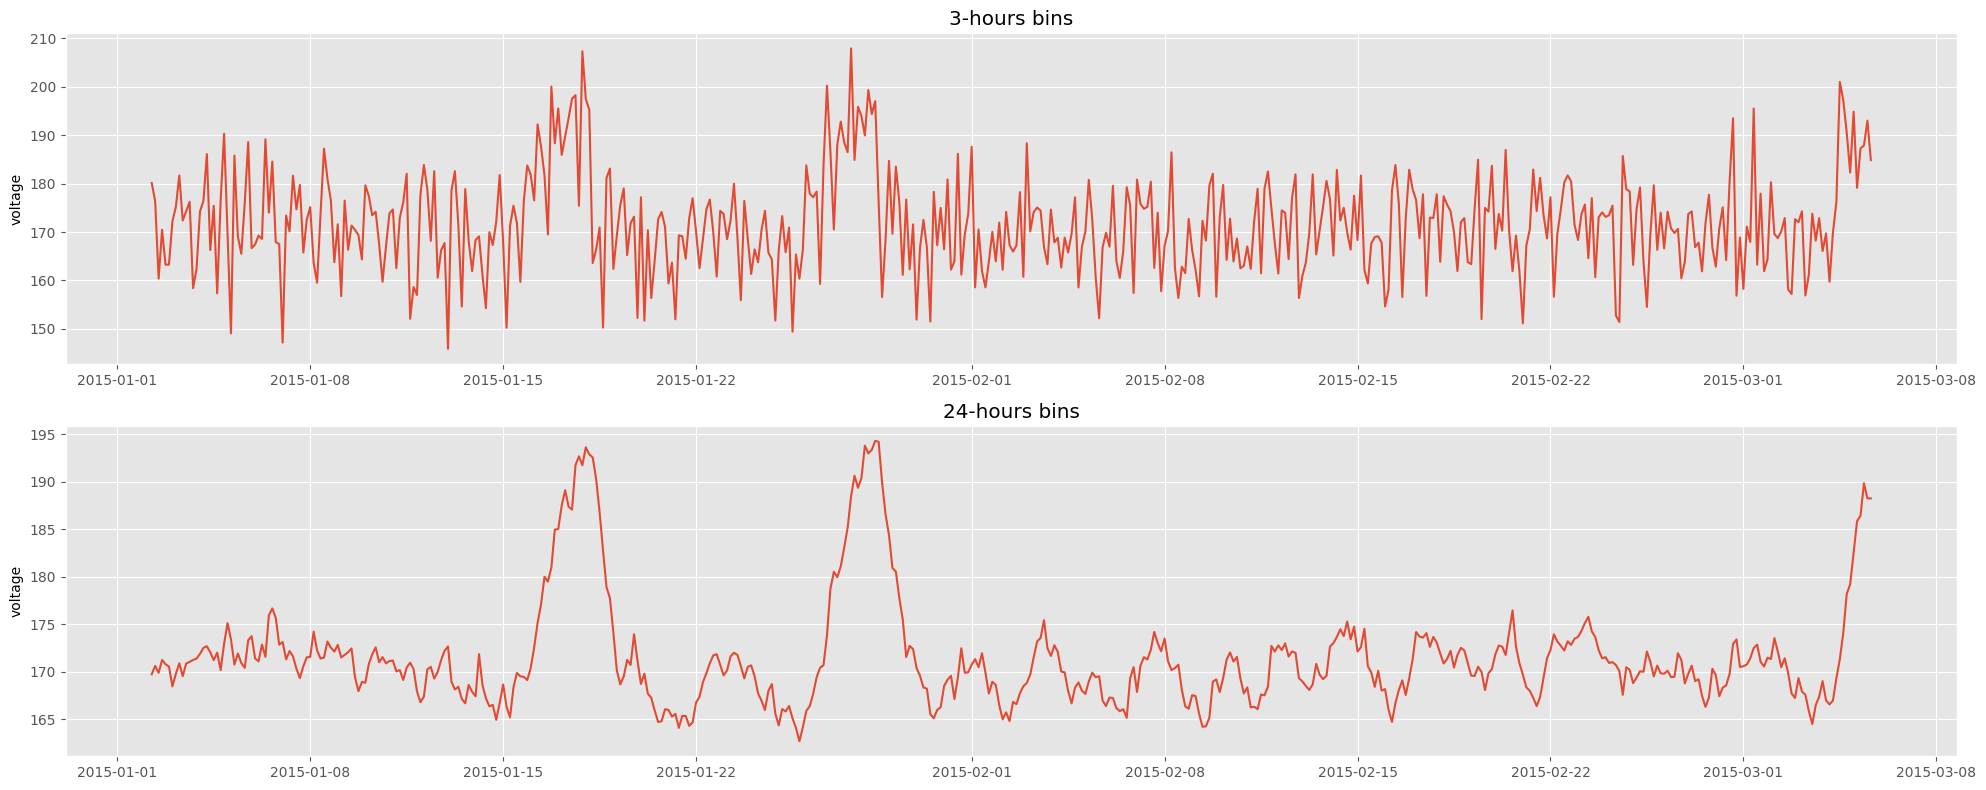

In [8]:
# plot voltage data (3-hour bins) and (24-hour bins)
fig, axs = plt.subplots(2, sharey='row', figsize=(20,8))

axs[0].plot(telemetry[telemetry['machineID'] == 1][:500]['datetime'], telemetry[telemetry['machineID'] == 1][:500]['voltmean_3h'], )
axs[0].set_title("3-hours bins")
axs[0].set_ylabel('voltage')

axs[1].plot(telemetry[telemetry['machineID'] == 1][:500]['datetime'], telemetry[telemetry['machineID'] == 1][:500]['voltmean_24h'], )
axs[1].set_title("24-hours bins")
axs[1].set_ylabel('voltage')

plt.tight_layout()

## Maintenance data

   These are the scheduled and unscheduled maintenance records which correspond to both regular inspection of components as well as failures. A record is generated if a component is replaced during the scheduled inspection or replaced due to a breakdown. 

   Each machine has 4 components, hence the 4 "comp" columns in this dataset. Let's load it with Pandas and make a plot of the days since last component replacement over time for machineID = 1.

In [9]:
# load data from csv
comp_rep = pd.read_csv('data/comp_rep.csv')

# format datetime field which comes in as string
comp_rep['datetime'] = pd.to_datetime(comp_rep['datetime'], format="%Y-%m-%d %H:%M:%S")

# show first rows
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1.0,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 07:00:00,1.0,19.041667,214.041667,154.041667,169.041667
2,2015-01-01 08:00:00,1.0,19.083333,214.083333,154.083333,169.083333
3,2015-01-01 09:00:00,1.0,19.125000,214.125000,154.125000,169.125000
4,2015-01-01 10:00:00,1.0,19.166667,214.166667,154.166667,169.166667


For the classification part we stick to the initial format of the data where we have the life over the time of a component since the last replacement of it.

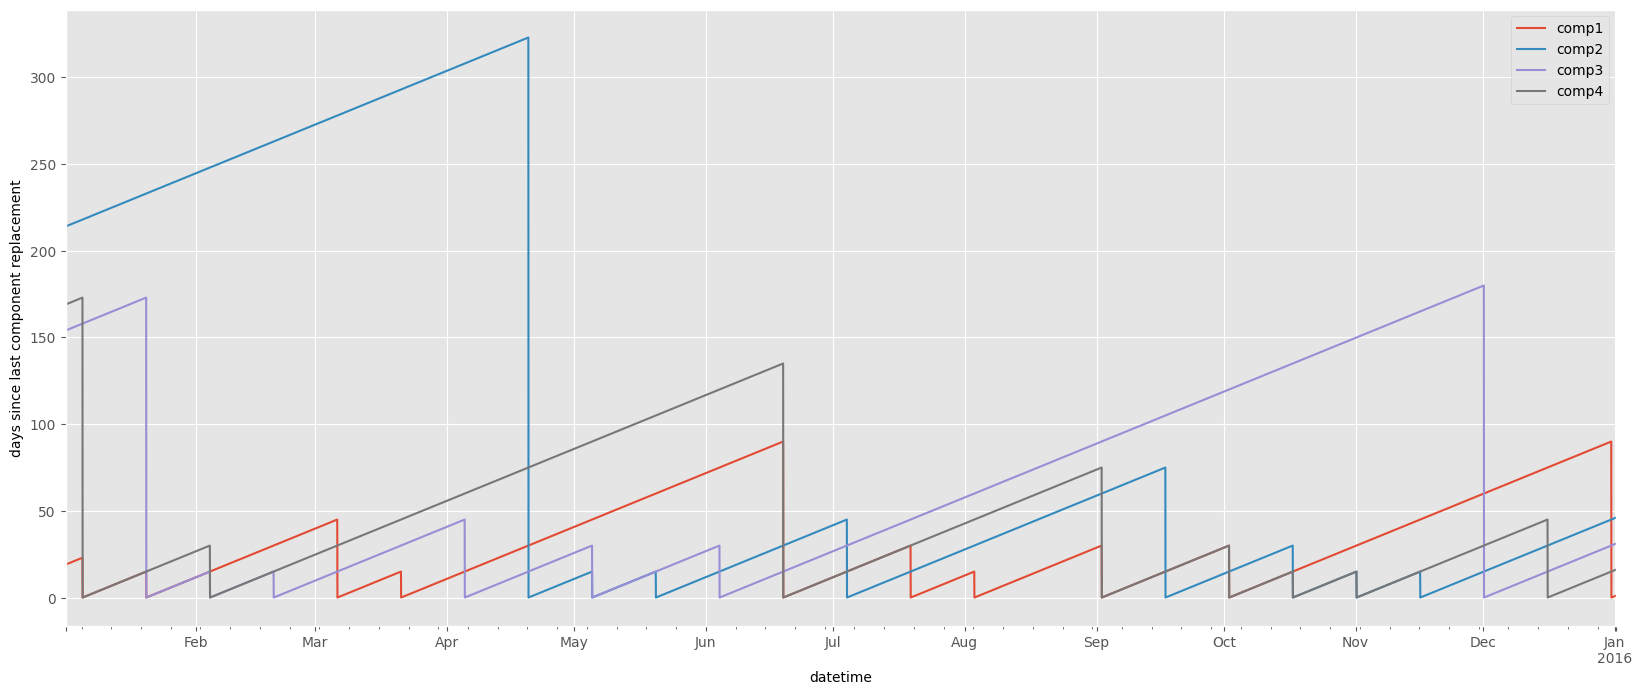

In [10]:
# visualize days since last component replacement for just the first machineID
comp_rep[comp_rep.machineID == 1].plot(x='datetime', 
                                             y=['comp1','comp2','comp3','comp4'],
                                             figsize=(20,8))
plt.ylabel('days since last component replacement')
plt.show()

Regarding the Regression Part we would like to revert the values of components in order to reflect the remaining life of a component until the next replacement of it.

In [61]:
comp_rep_rev = comp_rep[(comp_rep['machineID']==1)][['datetime','comp1','comp2','comp3','comp4']]

In [62]:
comp_rep_rev.head()

,datetime,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 07:00:00,19.041667,214.041667,154.041667,169.041667
2,2015-01-01 08:00:00,19.083333,214.083333,154.083333,169.083333
3,2015-01-01 09:00:00,19.125000,214.125000,154.125000,169.125000
4,2015-01-01 10:00:00,19.166667,214.166667,154.166667,169.166667


In [63]:
comp_rep_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8761 entries, 0 to 8760
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  8761 non-null   datetime64[ns]
 1   comp1     8761 non-null   float64       
 2   comp2     8761 non-null   float64       
 3   comp3     8761 non-null   float64       
 4   comp4     8761 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 410.7 KB


In [64]:
for comp in ['comp1','comp2','comp3','comp4']:
    comp_rep_rev[comp] = comp_rep_rev.apply(lambda row: row['datetime'] if row[comp]==0 else np.nan, axis=1)
    comp_rep_rev[comp].fillna(method='backfill', inplace=True)
#print(comp_rep_rev[comp_rep_rev['comp1'].isna()==False].index,comp_rep_rev[comp_rep_rev['comp2'].isna()==False].index,comp_rep_rev[comp_rep_rev['comp3'].isna()==False].index,comp_rep_rev[comp_rep_rev['comp4'].isna()==False].index)
#comp_rep_rev.dropna(inplace=True)
#for comp in ['comp1','comp2','comp3','comp4']:
    comp_rep_rev[comp] = comp_rep_rev[comp] - comp_rep_rev['datetime']
    comp_rep_rev[comp] = comp_rep_rev[comp].apply(lambda row: row.total_seconds()/86400)

In [65]:
comp_rep_rev.head()

,datetime,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,4.000000,109.000000,19.000000,4.000000
1,2015-01-01 07:00:00,3.958333,108.958333,18.958333,3.958333
2,2015-01-01 08:00:00,3.916667,108.916667,18.916667,3.916667
3,2015-01-01 09:00:00,3.875000,108.875000,18.875000,3.875000
4,2015-01-01 10:00:00,3.833333,108.833333,18.833333,3.833333


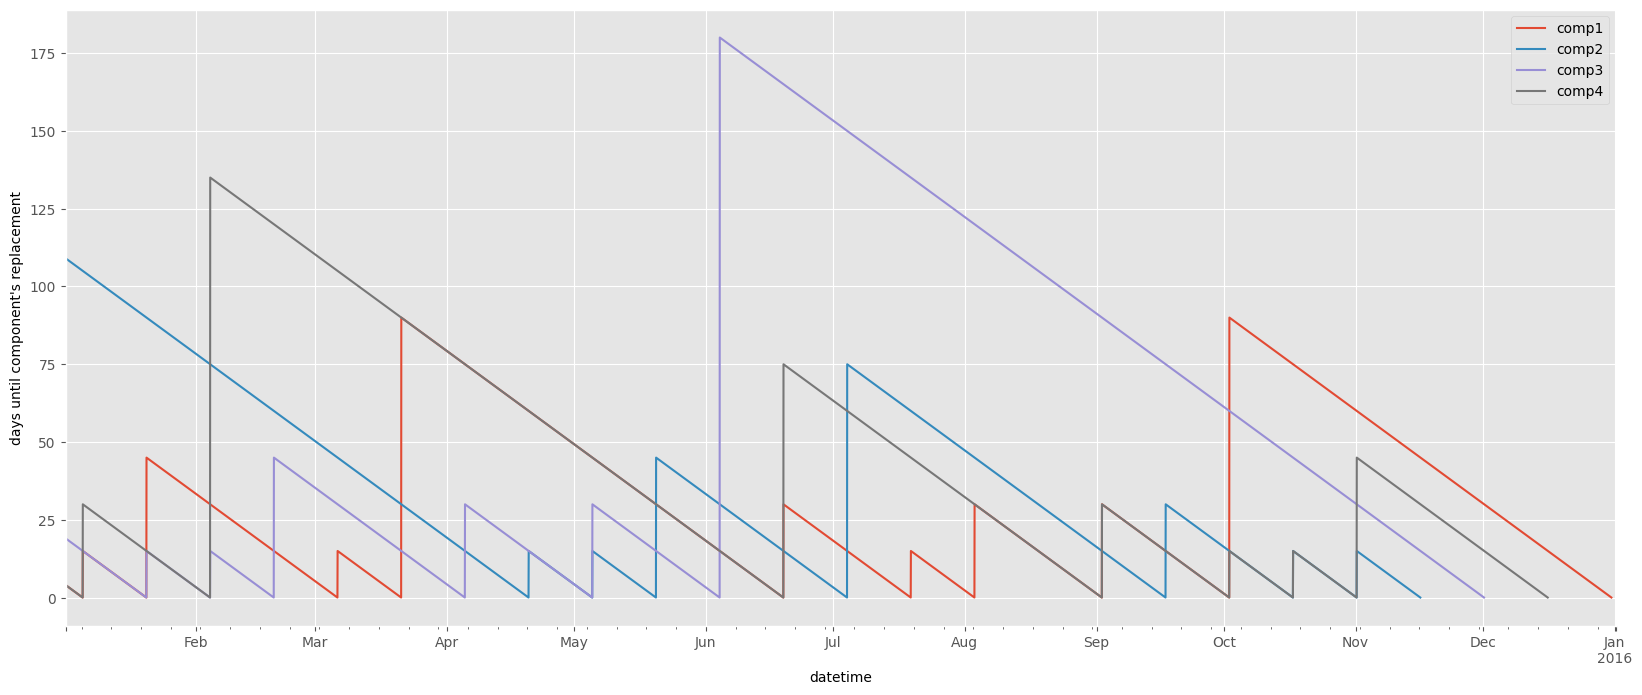

In [66]:
# visualize days since last component replacement
comp_rep_rev.plot(x='datetime', y=['comp1','comp2','comp3','comp4'], figsize=(20,8))
plt.ylabel("days until component's replacement")
plt.show()

# Error Data

These are non-breaking errors thrown while the machine is still operational and do not constitute as failures. Each machine has different components, each of which can fail at any moment. However, before they fail, it is common for a machine to start registering error codes indicating that something may not be well.

In [53]:
# load data from csv
error_count = pd.read_csv('data/error_count.csv')

# format datetime field which comes in as string
error_count['datetime'] = pd.to_datetime(error_count['datetime'], format="%Y-%m-%d %H:%M:%S")

# show first rows
error_count.head()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
0,1,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0
1,1,2015-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0
2,1,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0
3,1,2015-01-02 15:00:00,0.0,0.0,0.0,0.0,0.0
4,1,2015-01-02 18:00:00,0.0,0.0,0.0,0.0,0.0


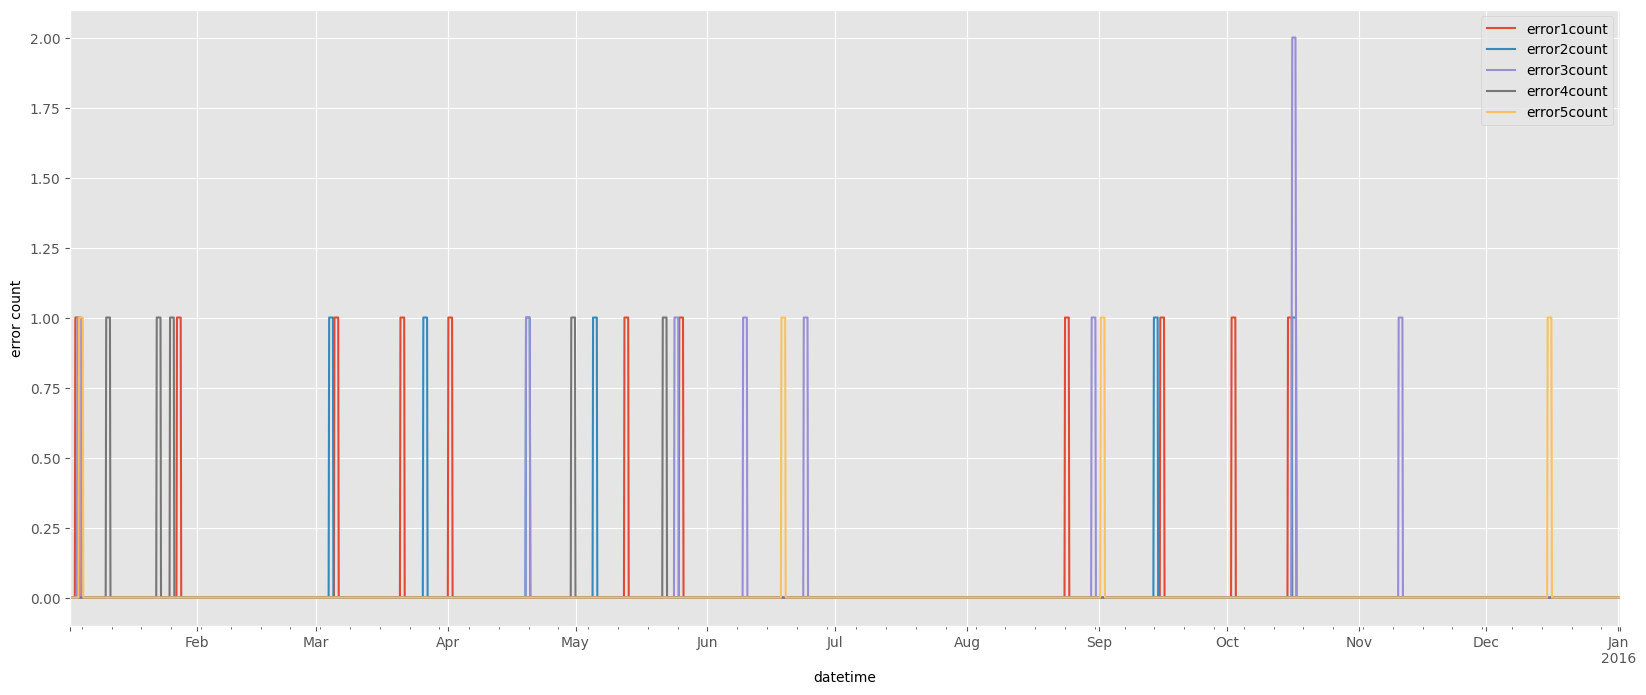

In [54]:
# visualize error count data for one machine

error_count[error_count.machineID == 1].plot(x='datetime', 
                                             y=['error1count','error2count','error3count','error4count','error5count'],
                                             figsize=(20,8))
plt.ylabel('error count')
plt.show()

## Machine characteristics

Information about each machine's model and how old it is.

In [56]:
# load data from csv
machines = pd.read_csv('data/machines.csv')

# show first rows
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [57]:
# turn "model" variable into dummy variables
machines['model'] = machines['model'].astype('category')
machines = pd.get_dummies(machines)
machines.head()

,machineID,age,model_model1,model_model2,model_model3,model_model4
0,1,18,0,0,1,0
1,2,7,0,0,0,1
2,3,8,0,0,1,0
3,4,7,0,0,1,0
4,5,2,0,0,1,0


## Failure Data

Lastly, the most important data source: the failure logs. This is registry of dates and times when each of the components (1-4) failed.

In [58]:
# load data from csv
failures = pd.read_csv('data/failures.csv')

# format datetime field which comes in as string
failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
#failures['failure'] = failures['failure'].astype('category')

print("Total number of failures: %d" % len(failures.index))
failures.head()

Total number of failures: 761


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


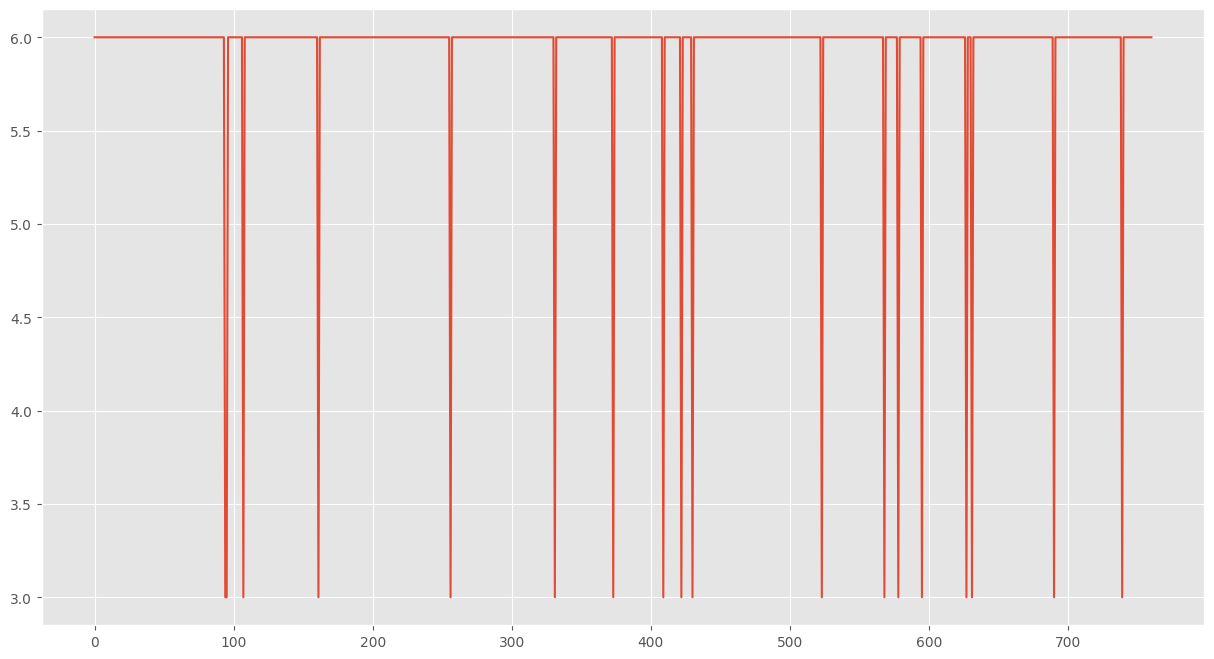

In [59]:
plt.plot(failures['datetime'].apply(lambda x: x.hour))

comp2    259
comp1    192
comp4    179
comp3    131
Name: failure, dtype: int64

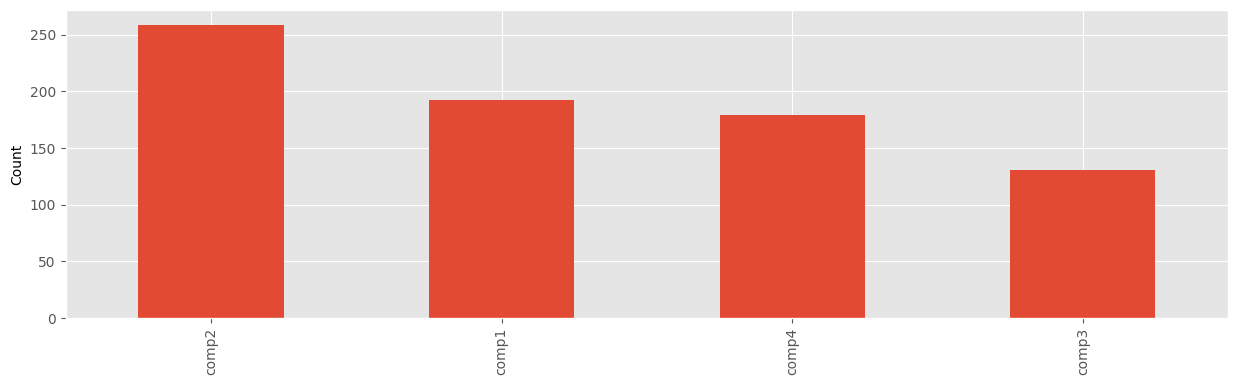

In [60]:
# plot distribution of failures by component
plt.figure(figsize=(15, 4))
failures['failure'].value_counts().plot(kind='bar')
plt.ylabel('Count')
failures['failure'].value_counts()